In [1]:
import re
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords  

In [2]:
stop_words = set(stopwords.words('english'))

In [3]:
from konlpy.tag import Komoran

In [4]:
kmoran = Komoran()

In [5]:
def lyrics_to_corpus(lyrics):
    lyrics = re.split('\r\n|\n',lyrics)
    #중복제거
    corpus = list(set(lyrics))
    result = " ".join(corpus)
    return result

In [6]:
def lexicon_tokenizer_komoran(corpus,kmoran):
    temp = []
    for i in kmoran.pos(corpus):
        if (i[1] == 'NNG' or i[1] == 'NNP'):
            temp.append(i[0])
        elif (i[1] == 'VV' or i[1] == 'VA'):
            temp.append(i[0] + "다")
        elif (i[1] == "SL"):
            if i[0].lower() not in stop_words:
                temp.append(i[0].lower())
    return temp

In [7]:
data = pd.read_excel('./감정별_가사_정리_10class.xlsx')
del data['Unnamed: 0']

In [8]:
sentence_data = pd.read_excel('../preprocessing/emotion_labels(ko).xlsb.xlsx') 

In [9]:
def df_to_emotion_corpus(df , emotion):
    emotion_df = df[df['감정'] == emotion]
    # 문장 분리 중복제거
    emotion_df['가사'] = emotion_df['가사'].map(lambda x : lyrics_to_corpus(x))
    # 특수문자 제거
    emotion_df['가사'] = emotion_df['가사'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)
    
    corpus = " ".join(emotion_df['가사'].to_list())
    return corpus

In [10]:
love_corpus = df_to_emotion_corpus(data , '사랑')
happyness_corpus = df_to_emotion_corpus(data , '행복')
fun_corpus = df_to_emotion_corpus(data , '신나는')
enthusiasm_corpus = df_to_emotion_corpus(data , '열정')
sadness_corpus = df_to_emotion_corpus(data , '슬픔')
anger_corpus = df_to_emotion_corpus(data , '분노')
longing_corpus = df_to_emotion_corpus(data , '그리움')
lonely_corpus = df_to_emotion_corpus(data , '외로움')
fear_corpus = df_to_emotion_corpus(data , '두려움')

<ipython-input-9-53b9105c66ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotion_df['가사'] = emotion_df['가사'].map(lambda x : lyrics_to_corpus(x))
<ipython-input-9-53b9105c66ff>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotion_df['가사'] = emotion_df['가사'].str.replace(pat=r'[^\w]', repl=r' ', regex=True)


In [12]:
emotion = {"love" : love_corpus ,
          "fun" : fun_corpus,
          "enthusiasm" : enthusiasm_corpus,
          "happyness" : happyness_corpus,
          "sadness" : sadness_corpus,
          "anger" : anger_corpus,
          "lonely" : lonely_corpus,
          "longing" : longing_corpus,
          "fear" : fear_corpus}

In [13]:
for i in range(len(emotion)):
    emotion_df = sentence_data[sentence_data['emotion_v2'] == i+2]
    corpus = " ".join(emotion_df['lyrics splited'].values)
    emotion[list(emotion.keys())[i]] = emotion[list(emotion.keys())[i]] + corpus

In [14]:
emotion_count = {}
vocab = {}
for i in range(len(emotion)):
    emotion_key = list(emotion.keys())[i]
    emotion_count[emotion_key] = Counter(lexicon_tokenizer_komoran(emotion[emotion_key],kmoran)).most_common(500)
    for words , counts in emotion_count[emotion_key]:
        if words in list(vocab.keys()):
            vocab[words][emotion_key] = counts
        else:
            vocab[words] = {emotion_key : counts }

In [15]:
vocab

{'사랑': {'love': 387,
  'enthusiasm': 4,
  'happyness': 10,
  'sadness': 114,
  'anger': 42,
  'lonely': 28,
  'longing': 41,
  'fear': 13},
 '있다': {'love': 141,
  'fun': 46,
  'enthusiasm': 89,
  'happyness': 88,
  'sadness': 108,
  'anger': 58,
  'lonely': 82,
  'longing': 53,
  'fear': 37},
 '하다': {'love': 133,
  'fun': 68,
  'enthusiasm': 143,
  'happyness': 62,
  'sadness': 191,
  'anger': 194,
  'lonely': 69,
  'longing': 67,
  'fear': 63},
 '나다': {'love': 90,
  'fun': 66,
  'enthusiasm': 141,
  'happyness': 47,
  'sadness': 147,
  'anger': 117,
  'lonely': 70,
  'longing': 47,
  'fear': 54},
 '말': {'love': 88,
  'fun': 35,
  'enthusiasm': 57,
  'happyness': 24,
  'sadness': 114,
  'anger': 103,
  'lonely': 22,
  'longing': 28,
  'fear': 28},
 '날': {'love': 85,
  'fun': 24,
  'enthusiasm': 44,
  'happyness': 33,
  'sadness': 89,
  'anger': 68,
  'lonely': 45,
  'longing': 51,
  'fear': 35},
 '보다': {'love': 78,
  'fun': 56,
  'enthusiasm': 53,
  'happyness': 42,
  'sadness': 100,
 

In [16]:
emotion_keys = list(emotion.keys())
for word in list(vocab.keys()):
    total = sum(vocab[word].values())
    for keys in emotion_keys:
        try:
            vocab[word][keys] = round( (vocab[word][keys]  / total) , 2 )
        except KeyError:
            pass

In [116]:
# # 상위 3개 까지만 감정 점수에 포함
# for keys in vocab.keys():
#     vocab[keys] = dict(sorted(vocab[keys].items(), key=lambda x: x[1], reverse=True))
#     try :
#         for remove_emotion in list(vocab[keys].keys())[3:]:
#             vocab[keys].pop(remove_emotion)
#     except:
#         pass

In [17]:
vocab

{'사랑': {'love': 0.61,
  'enthusiasm': 0.01,
  'happyness': 0.02,
  'sadness': 0.18,
  'anger': 0.07,
  'lonely': 0.04,
  'longing': 0.06,
  'fear': 0.02},
 '있다': {'love': 0.2,
  'fun': 0.07,
  'enthusiasm': 0.13,
  'happyness': 0.13,
  'sadness': 0.15,
  'anger': 0.08,
  'lonely': 0.12,
  'longing': 0.08,
  'fear': 0.05},
 '하다': {'love': 0.13,
  'fun': 0.07,
  'enthusiasm': 0.14,
  'happyness': 0.06,
  'sadness': 0.19,
  'anger': 0.2,
  'lonely': 0.07,
  'longing': 0.07,
  'fear': 0.06},
 '나다': {'love': 0.12,
  'fun': 0.08,
  'enthusiasm': 0.18,
  'happyness': 0.06,
  'sadness': 0.19,
  'anger': 0.15,
  'lonely': 0.09,
  'longing': 0.06,
  'fear': 0.07},
 '말': {'love': 0.18,
  'fun': 0.07,
  'enthusiasm': 0.11,
  'happyness': 0.05,
  'sadness': 0.23,
  'anger': 0.21,
  'lonely': 0.04,
  'longing': 0.06,
  'fear': 0.06},
 '날': {'love': 0.18,
  'fun': 0.05,
  'enthusiasm': 0.09,
  'happyness': 0.07,
  'sadness': 0.19,
  'anger': 0.14,
  'lonely': 0.09,
  'longing': 0.11,
  'fear': 0.07},

In [18]:
def lexicon_emotion_clf(sentence):
    temp = Counter()
    for word in lexicon_tokenizer_komoran(sentence,kmoran):
        try:
            temp = temp + Counter(vocab[word])
        except KeyError:
            pass
    emotion = list(temp.keys())
    score = list(temp.values())
    
    plt.pie(score, labels=emotion, autopct='%.1f%%')
    plt.show()
    
    return [k for k,v in dict(temp).items() if max(dict(temp).values()) == v]

In [19]:
test = """미래라는 종이에 나라는 글씨를 써
펜을 들고 용기를 내어 손을 뻗어
종이는 이미 검게 칠해져버렸고
아마 내가 설 자린 없던게 아닐까

다 지나온 길인걸
기억은 생기를 잃고
다가올 일들이
어두워 보이지 않아

맞이할 흐름이 두려워
고개를 떨군 것도
나아갈 자신이 없어
내딛지 못했던 것도

일상과도 같은 무력함에
지배당한 것도
모두 제자리에 다 묶여진 것 같아

과거라는 책자에 나라는 글씨를 봐
이렇게 텅 빈 자리가 많이있었나
난 밝게 빛났다 착각을 하고 있었고
실은 검디검은 글씨일 뿐이었다고

다 지나온 길인걸
기억은 생기를 잃고
다가올 일들이
어두워 보이지 않아

맞이할 흐름이 두려워
고개를 떨군 것도
나아갈 자신이 없어
내딛지 못했던 것도

일상과도 같은 무력함에
지배당한 것도
모두 제자리에 다 묶여진 것 같아

Rise up
I said rise up

난 모르겠어 난 모르겠어
난 모르겠어 난 모르겠어"""

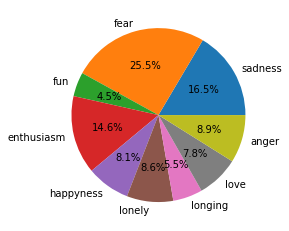

['fear']

In [20]:
lexicon_emotion_clf(lyrics_to_corpus(test))

In [21]:
#단어사전 저장
np.save('emotion_vocab_9class.npy', vocab)

### 한국어 명사 구 , 형용사 구 , 부사 구 활용 연구